# Comparaison de la prediction pour Poisson (sdf apprise) avec solution sur-raffinée FEM

In [1]:
import sys
import argparse

from scar.problem.Case import *
from scar.utils import *
from scar.equations.run_Poisson2D import *
from scar.geometry import Geometry2D

import dolfin as df
from dolfin import *
import mshr

Using device: cuda
cuda devices:        1
cuda current device: 0
cuda device name:    NVIDIA RTX 2000 Ada Generation Laptop GPU
torch loaded; device is cuda
torch loaded; device is cuda


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


## Get PINNs prediction

bc_points.shape = (2000, 2), bc_normals.shape = (2000, 2)
ICIIIII : tv_loss_f =  MSELoss()
>> load network /home/flecourtier/Bureau/Thèse/networks/EikonalLap2D/Bean/models/model_2.pth
norm_grad_norm_gradu : torch.Size([20000, 1])
norm_grad_norm_gradu : torch.Size([20000, 1])
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
>> load network /home/flecourtier/Bureau/Thèse/networks/Poisson2D/Bean/SDEikonalLap/ConstantForce/form_2/0.0/models/model_2.pth


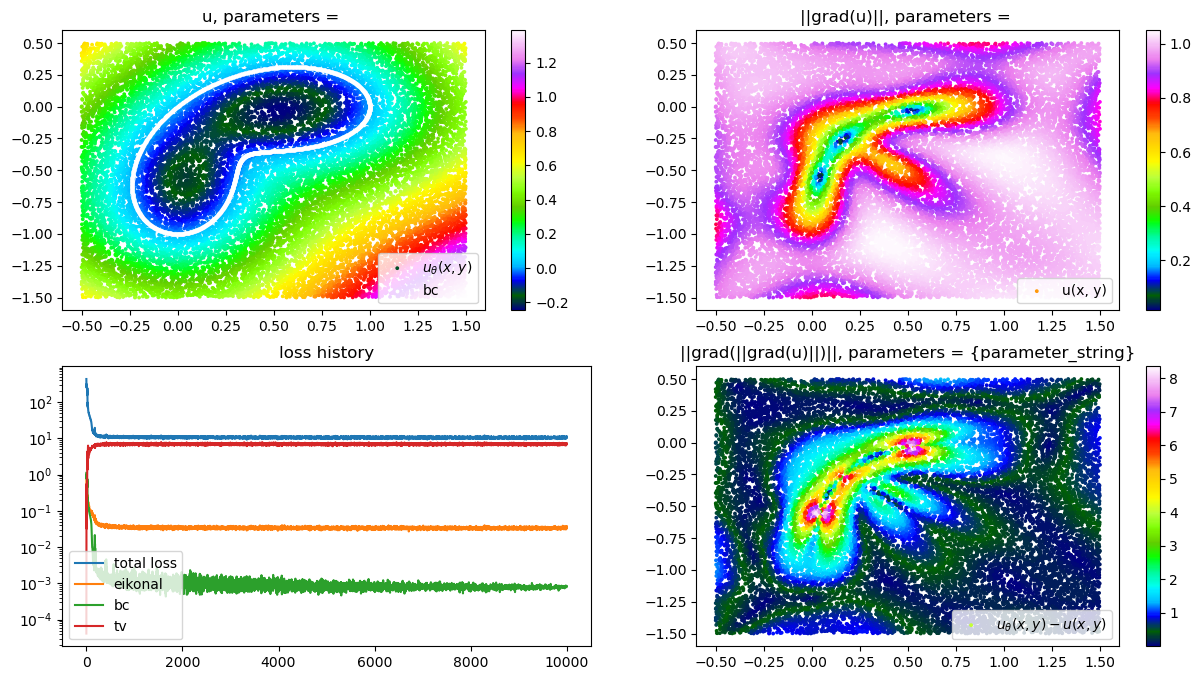

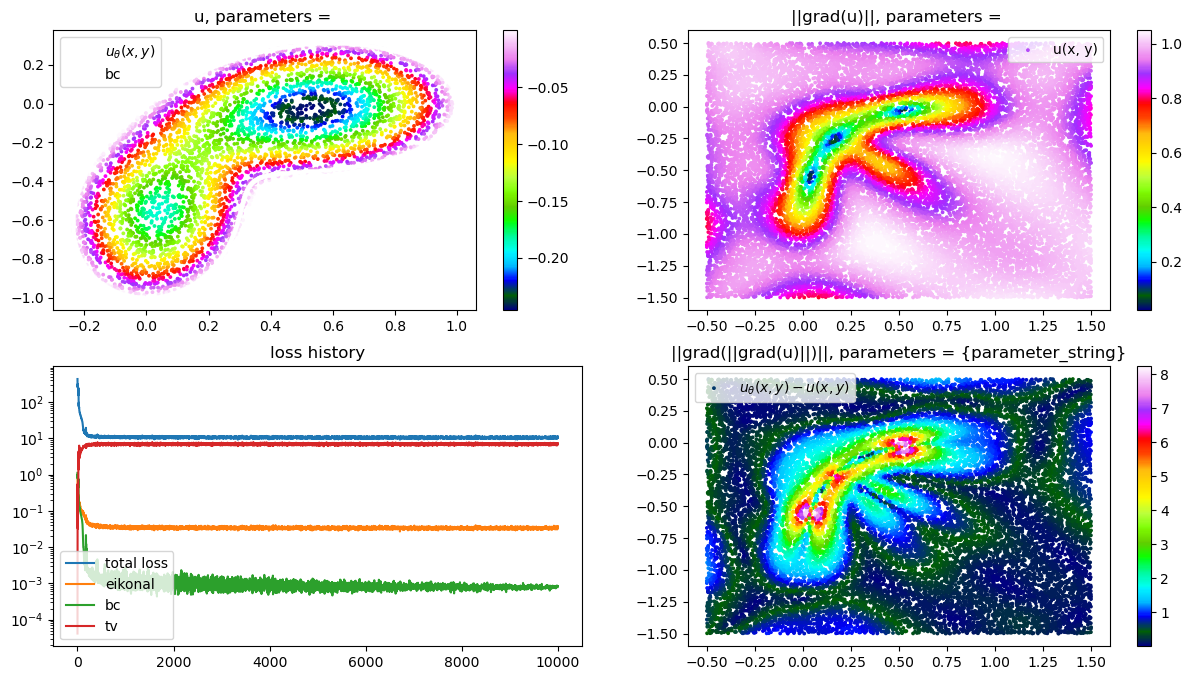

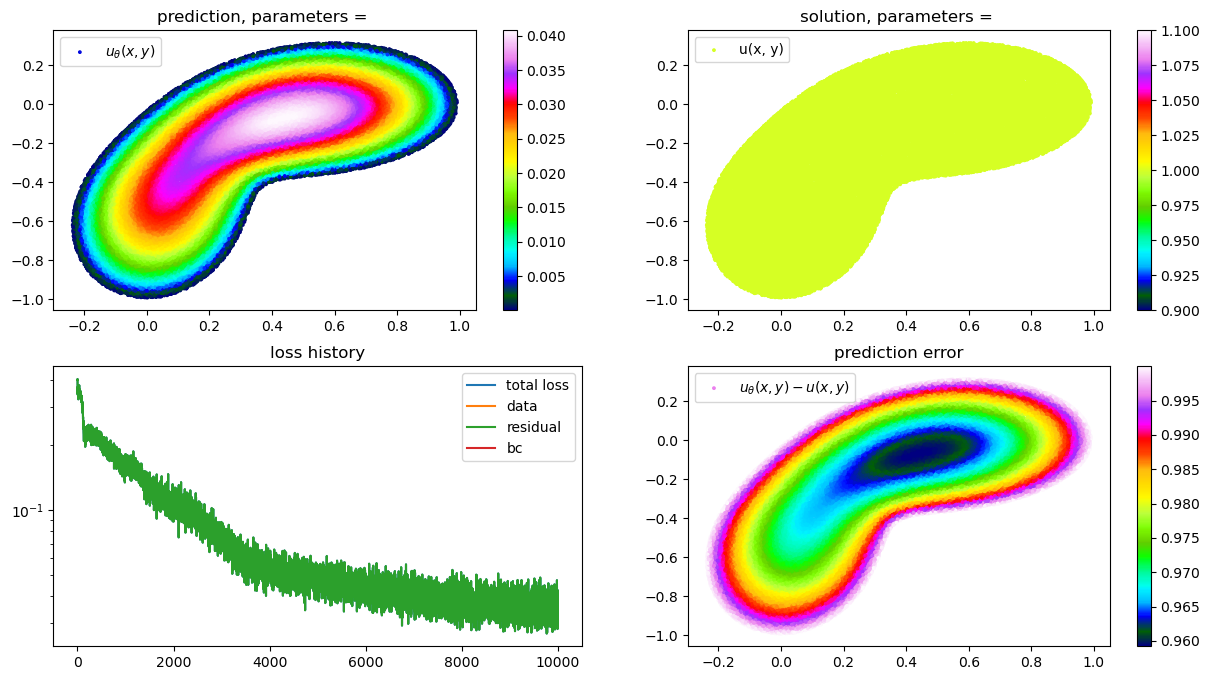

In [2]:
config = 2
casefile = "../../testcases/"+"form_case_lap.json"
casefile_dict = read_config(casefile)
cas = Case(casefile)

dir_name = "../../"+cas.dir_name

# load model
config_filename = dir_name+"models/config_"+str(config)+".json"
config_dict = read_config(config_filename)

trainer = run_Poisson2D(cas,config,config_dict,save_sampling=False,save_phi=False,new_training=False);

## Get FEM solution

In [3]:
geom_class_name = casefile_dict["geometry"]
geom_class = get_class(geom_class_name,Geometry2D)
form = geom_class()

### Create mesh

In [4]:
def dist(pt1,pt2):
    return np.sqrt((pt1[0]-pt2[0])**2+(pt1[1]-pt2[1])**2)

def tri(c_t):
    n_bc_points = c_t.shape[0]
    c_t_tri = [c_t[0,:]]
    c_t = np.delete(c_t,0,axis=0)
    for _ in range(1,n_bc_points):
        pt1 = c_t_tri[-1]
        # point le plus proche de pt1
        dist_pts = [dist(pt1,c_t[i,:]) for i in range(len(c_t))]
        i_min = np.argmin(dist_pts)
        c_t_tri.append(c_t[i_min,:])
        c_t = np.delete(c_t,i_min,axis=0)
    return np.array(c_t_tri)

In [5]:
n_bc_points = 1000
t = np.linspace(0,1,n_bc_points)
c_t = form.c(t)
c_t = np.array(c_t.T)

c_t_tri = tri(c_t)
c_t_tri = np.concatenate([c_t_tri,np.array([c_t_tri[0]])],axis=0)

/home/flecourtier/Bureau/Thèse/src/scar/geometry/Geometry2D.py:147: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400441250/work/torch/csrc/utils/tensor_new.cpp:261.)
  return self.R()@torch.Tensor([x,y])


In [6]:
domain_vertices = [df.Point(c_t_tri[i,0],c_t_tri[i,1]) for i in range(n_bc_points)]
domain = mshr.Polygon(domain_vertices)
mesh_form = mshr.generate_mesh(domain, 100)
# mesh_form

### Get FEM solution

In [7]:
V = FunctionSpace(mesh_form, "CG", 1)
dx = Measure("dx", domain=mesh_form)

g = Constant("0.0")
bc = DirichletBC(V, g, "on_boundary")

f_expr = Constant("1.0")

u = TrialFunction(V)
v = TestFunction(V)

# Resolution of the variationnal problem
a = inner(grad(u), grad(v)) * dx
l = f_expr * v * dx

A = df.assemble(a)
L = df.assemble(l)
bc.apply(A, L)

u_FEM = Function(V)
solve(A,u_FEM.vector(),L)

1

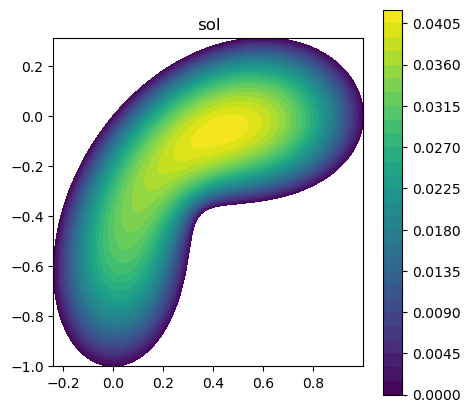

In [8]:
plt.figure(figsize=(5,5))
c = plot(u_FEM, title="sol")
plt.colorbar(c)

## Compare solution

In [9]:
def get_test_sample(V,parameter_domain):
    # get coordinates of the dof
    XXYY = V.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)

    # get parameters
    nb_params = len(parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    if shape[1] == 0:
        mu_test = torch.zeros(shape)
    else:
        ones = torch.ones(shape)
        mu_test = (torch.mean(parameter_domain, axis=1) * ones).to(device)

    return X_test,mu_test

parameter_domain = trainer.pde.parameter_domain
X_test,mu_test = get_test_sample(V,parameter_domain)

pred = trainer.network.setup_w_dict(X_test, mu_test)
phi_tild = pred["w"][:,0].cpu().detach().numpy()
u_PINNs = Function(V)
u_PINNs.vector()[:] = phi_tild.copy()

norm_L2_PINNs = None
norm_L2_PINNs = (assemble((((u_FEM - u_PINNs)) ** 2) * dx) ** (0.5)) / (assemble((((u_FEM)) ** 2) * dx) ** (0.5))

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [10]:
norm_L2_PINNs

0.08275868677665904

Object cannot be plotted directly, projecting to piecewise linears.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


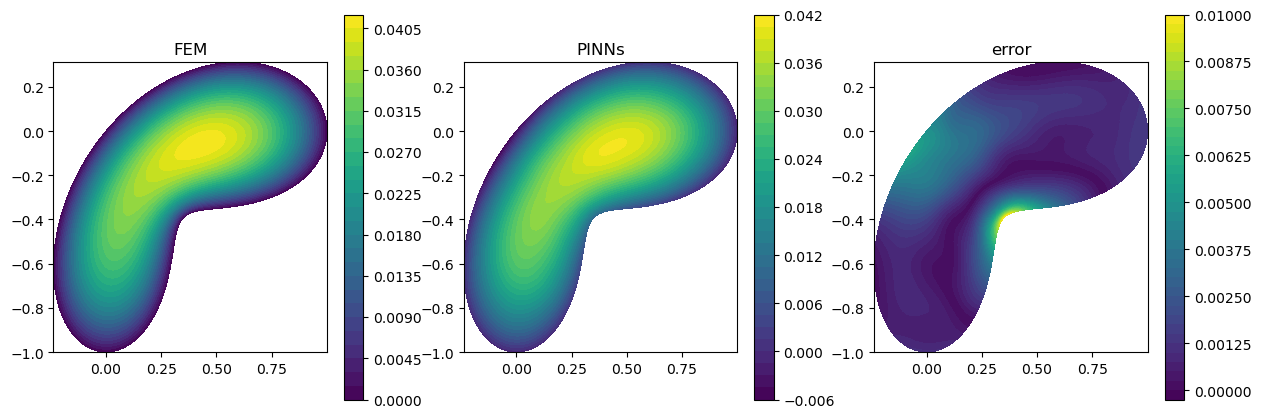

In [14]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
c = plot(u_FEM, title="FEM")
plt.colorbar(c)

plt.subplot(1,3,2)
c = plot(u_PINNs, title="PINNs")
plt.colorbar(c)

plt.subplot(1,3,3)
error = abs(u_FEM-u_PINNs)
c = plot(error, title="error")
plt.colorbar(c)